In [1]:
import time
import logging
from sys import stdout
from collections import deque

import cv2
import PIL
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from mlagents.envs.environment import UnityEnvironment

from agent import Agent

# set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

writer = SummaryWriter()

# env_name = 'sep_28'
env_name = 'oct_22'
path = "C:/data/ml-agents/scripts/envs/{}/UnitySDK.exe".format(env_name)
# env = UnityEnvironment(file_name="./envs/%s/%s.x86_64" % (env_name, env_name), worker_id=1, seed=1, no_graphics=False)
env = UnityEnvironment(file_name=path, worker_id=1, seed=1, no_graphics=False)


INFO:mlagents.envs:
'StationAcademy' started successfully!
Unity Academy name: StationAcademy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: DRLBrain
        Number of Visual Observations (per agent): 2
        Vector Observation space size (per agent): 3
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): [2, 2]
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain_name, brain

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
logger.info('Number of actions: %s' % str(action_size))

# examine the vector space 
state = env_info.vector_observations[0]
logger.info('States look like: %s' % str(state))
state_size = len(state)
logger.info('States have length: %s' % str(state_size))

# examine the visual space
img = np.asarray(env_info.visual_observations)
# imgplt = plt.imshow(img[0][0])
height, width, channel = img[0][0].shape
logger.info('Shape of image: %s' % str(img[0][0].shape))

model_weight_name = 'checkpoint.pth'
agent = Agent(state_size=300, action_size=9, seed=0)

INFO:root:Number of actions: [2, 2]
INFO:root:States look like: [   0.            0.            0.            0.            0.
    0.         -659.69000244   -2.16580009  200.38999939]
INFO:root:States have length: 9
INFO:root:Shape of image: (300, 300, 3)


In [22]:
def get_action(action):
    move_forward  = action // 3
    rotate = action % 3
    return [move_forward, rotate]

def dqn(env_info, n_episodes=1, max_t=2000, eps_start=1.0, eps_end=0.01, 
        eps_decay=0.995, target_scores=1.0, video_flag=True, load_prev_model=None):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once 
                            it reaches this scores
        video_flag (boolean): a flag for whether to record video, if set to True, 
                            video would be recorded for every 20 episodes
    
    Returns
    ======
        scores in 2-d array
        positions in 2-d array
    
    """
    # load previous trained result
    if not load_prev_model == None:
        agent.qnetwork_local.load_state_dict(torch.load(load_prev_model))
    
    start = time.time()                       # Start time
    scores = []                               # list containing scores from each episode
    positions = []                            # position list
    scores_window = deque(maxlen=100)         # last 100 scores
    eps = eps_start                           # initialize epsilon
    
    
    width, height, channel = [300, 300, 3]
    
    for i_episode in range(1, n_episodes+1):
        
        video_flag = (i_episode % 20 == 0)
        
        # start video recording 
        if video_flag:
            fourcc = cv2.VideoWriter_fourcc('M','S','V','C') #Microspoft Video 1
            video  = cv2.VideoWriter('output_sep_18_%s.avi' % (str(i_episode)), fourcc, 30, (width, height))
            
        # Reset env and score at the beginning of episode
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment 
        
        # get the current visual state
        state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1)) 
        
        # initialize the score
        score = 0
        
        # storing temporary path for an episode
        position_epi = []
        
        for t in range(max_t):
            
            if video_flag:
                video.write(np.asarray(env_info.visual_observations)[0][0])
                
            action = agent.act(state, eps)
            
            # translate action variable into forward, rotate, and right
            action_transformed = get_action(action)
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            next_state = np.transpose(np.asarray(env_info.visual_observations)[0][0], 
                                      (2, 0, 1)) # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            
            score += reward
            
            position_epi.append(env_info.vector_observations[0][-3:].tolist())
            
            stdout.write('\r t:{}, position:{}, score:{:.3f}'.format(str(t), 
                                    str(env_info.vector_observations[0][-3:]), score))
            stdout.flush()
                                
        positions.append(position_epi)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\nEpisode {}\tAverage Score: {:.2f}\t Last Move {}\n'.format(i_episode, 
                                                        np.mean(scores_window), action_transformed), end="")
        if i_episode % 10 == 0:
            # torch.save(agent.qnetwork_local.state_dict(), 'model_%s' % str(i_episode))
            torch.save(agent.qnetwork_local.state_dict(), 'model_latest')
        
        # add rewards to writer
        writer.add_scalar('total_rewards', score, i_episode)
                
        # if np.mean(scores_window)>=target_scores:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
        #                                                                      np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), model_weight_name)
        #     break
        
        if video_flag:
            cv2.destroyAllWindows()
            video.release()
    
    writer.close()

    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), model_weight_name)

    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f}".format(time_elapsed))
    
    return scores, positions

In [23]:
load_prev_model = 'model_latest'
scores, positions = dqn(env_info, n_episodes=100, max_t=2000, eps_start=1.0, 
                        eps_end=0.01, eps_decay=0.995, target_scores=1.0,
                        video_flag=False, load_prev_model=load_prev_model)

 t:1999, position:[-730.60534668   -2.00203896  186.64065552], score:-9.9900
Episode 1	Average Score: -9.99	 Last Move [2, 2]
 t:1999, position:[-565.17492676   -1.83537197  220.73513794], score:0.0200
Episode 2	Average Score: -4.98	 Last Move [1, 0]
 t:1999, position:[-704.35522461   -2.00203896  189.31008911], score:-9.9900
Episode 3	Average Score: -6.65	 Last Move [0, 0]
 t:1999, position:[-735.65307617   -2.00203896  181.94429016], score:-20.000
Episode 4	Average Score: -9.99	 Last Move [0, 1]
 t:1999, position:[-669.3963623    -2.00203896  198.37286377], score:-9.9900
Episode 5	Average Score: -9.99	 Last Move [2, 1]
 t:1999, position:[-612.4262085    -2.00065923  202.05052185], score:-9.9900
Episode 6	Average Score: -9.99	 Last Move [0, 0]
 t:1999, position:[-687.80004883   -2.97287583  100.0951004 ], score:-9.990
Episode 7	Average Score: -9.99	 Last Move [1, 2]
 t:1999, position:[-654.79614258   -1.97558403  179.26968384], score:0.0200
Episode 8	Average Score: -8.74	 Last Move [2

 t:1999, position:[-357.32434082    4.61124516  123.68681335], score:-20.00017.370
Episode 65	Average Score: -11.68	 Last Move [2, 0]
 t:1999, position:[-487.35339355    5.08242846  155.52249146], score:-20.000
Episode 66	Average Score: -11.81	 Last Move [2, 2]
 t:1999, position:[-626.69226074    5.51708555  170.90385437], score:-20.000
Episode 67	Average Score: -11.93	 Last Move [0, 1]
 t:1999, position:[-548.31280518    5.30661011  166.82739258], score:-20.000
Episode 68	Average Score: -12.05	 Last Move [0, 0]
 t:1999, position:[-625.60577393    5.51385212  170.94265747], score:-20.000
Episode 69	Average Score: -12.17	 Last Move [0, 2]
 t:1999, position:[-642.4510498     5.56462908  170.30197144], score:-20.000
Episode 70	Average Score: -12.28	 Last Move [0, 2]
 t:1999, position:[-510.14050293    5.0646286   152.38064575], score:-20.000
Episode 71	Average Score: -12.39	 Last Move [0, 0]
 t:1999, position:[-438.146698      4.8252573   133.48207092], score:-20.000
Episode 72	Average Sc

In [24]:
env_info = env.reset(train_mode=True)[brain_name]

In [26]:
a = deque(maxlen=5)
a.append([0,1,1,1])

In [27]:
goals = [[-252.8, -26.6, 118.7], [-184.0, -25.9, 89.9], 
         [-121.3, -19.5, 3.8], [-162.1, -27.1, 13.3], [-202.0, -27.3, 11.1],
        [40.9, -20.75, -30.8], [75.5, -28.1, -38.7]]
goals = [[i[0] - 388.5, i[1] + 24.4, i[2] + 80.5] for i in goals]
final_goal = [-342.9, 3.65, 48.0]

In [28]:
start = [positions[0][0][0], positions[0][0][1], positions[0][0][2]]

In [29]:
pos = []
for i in range(len(positions)):
    # ignore the last item, as it might start from the origin
    a = [[a[0], a[1], a[2]] for a in positions[i]]
    pos.append(np.asarray(a[:-2]))

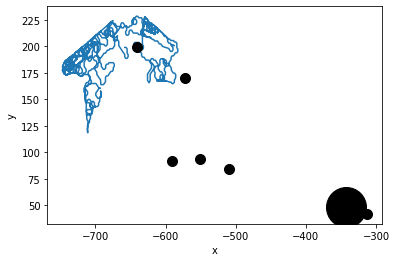

In [109]:
# final_goal = [-382.46, 54.69, 4]
for i in range(len(pos)):
    if i == 0:
        plt.plot(pos[i][:,0], pos[i][:,2])

for i in range(len(goals)):
    plt.plot(goals[i][0], goals[i][2], marker='o', markersize=10, color="black")

plt.plot([final_goal[0]], [final_goal[2]], marker='o', markersize=40, color="black")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [88]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# point_a = [[1093 - 888, 592 - 394], [1093 - 294, 592 - 92]]
point_a = [[205, 198], [799, 500]]
# point_b = [[-252.8 - 388.5, 118.7 + 80.5], [75.5 - 388.5, -38.7 + 80.5]]
point_b = [[-641.3, -199.2], [-313.0, -41.8]]

a = math.sqrt((point_a[0][0] - point_a[1][0])**2 + (point_a[0][1] - point_a[1][1])**2)
b = math.sqrt((point_b[0][0] - point_b[1][0])**2 + (point_b[0][1] - point_b[1][1])**2)
ratio = a / b
plus = [point_a[0][0] - point_b[0][0] * ratio, point_a[0][1] - point_b[0][1] * ratio]
print(point_b[0][0] * ratio + plus[0], point_b[0][1] * ratio + plus[1])
print(point_b[1][0] * ratio + plus[0], point_b[1][1] * ratio + plus[1])
# print([[i[0] * ratio + , i[i] * ratio + ] for ])

205.0 197.99999999999994
805.8731636688163 486.0823513904103


In [89]:
ratio

1.8302563620737633

In [96]:
trans_pos = [np.array([[j[0] * ratio + plus[0], j[1], j[2] * ratio + plus[1]] for j in i]) for i in pos]

In [97]:
# trans_pos

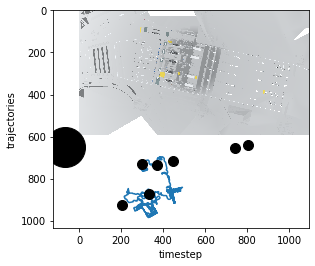

In [98]:
img = mpimg.imread('./plan.png')
plt.imshow(img)

for i in range(len(trans_pos)):
    if i == 11:
        plt.plot(trans_pos[i][:,0], trans_pos[i][:,2])

for i in range(len(goals)):
    plt.plot(goals[i][0]  * ratio + plus[0], goals[i][2]  * ratio + plus[1], marker='o', markersize=10, color="black")

plt.plot([final_goal[0] * ratio + plus[1]], [final_goal[2] * ratio + plus[1]], marker='o', markersize=40, color="black")
plt.xlabel('timestep')
plt.ylabel('trajectories')
plt.show()

In [99]:
imgs = np.expand_dims(np.asarray(env_info.visual_observations)[0][0], axis=0)
input = np.transpose(imgs, (0, 3, 1, 2))
input = np.concatenate([input, input, input, input], 0)
print(input.shape)

m1  = torch.nn.Conv2d(3, 32, kernel_size=8, stride=4)
m2  = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
m3  = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
fc4 = torch.nn.Linear(34 * 34 * 64, 512)
fc5 = torch.nn.Linear(512, 9)

input = torch.randn(1, 3, 300, 300)
output1 = m1(input)
print(output1.shape)
output2 = m2(output1)
print(output2.shape)
output3 = torch.flatten(m3(output2))
print(output3.shape)
output4 = fc4(output3)
print(output4.shape)
output5 = fc5(output4)

# fc5(fc4(m3(m2(m1(input)))))


(4, 3, 300, 300)
torch.Size([1, 32, 74, 74])
torch.Size([1, 64, 36, 36])
torch.Size([73984])
torch.Size([512])


In [ ]:
input = torch.randn(3, 300, 300)
input = input.unsqueeze(0)

In [ ]:
input.shape

In [ ]:
output5

In [ ]:
plt.imshow(np.asarray(env_info.visual_observations)[0][0])

In [ ]:

# plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(scores)), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

In [ ]:
print(agent.chck[1])

In [ ]:
agent.qnetwork_local(agent.chck[0].unsqueeze(0))

### Watch the agent running ( Using saved weights)

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(model_weight_name))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### Close Unity ML Environment

In [ ]:
env.close()